[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Fear-Lesson-Plans/blob/master/Lesson-5-D2/betterD2.ipynb)

In [1]:
#@title download files
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install ipywidgets &> /dev/null
    !pip install neuron &> /dev/null
    !pip install bmtk &> /dev/null
    # install for spike gen could always copy function into here

    !git clone https://github.com/cyneuro/Fear-Lesson-Plans &> /dev/null
    %cd Fear-Lesson-Plans/Lesson-5-D2

if(os.path.exists('x86_64')==False):
    os.system('nrnivmodl modfiles')

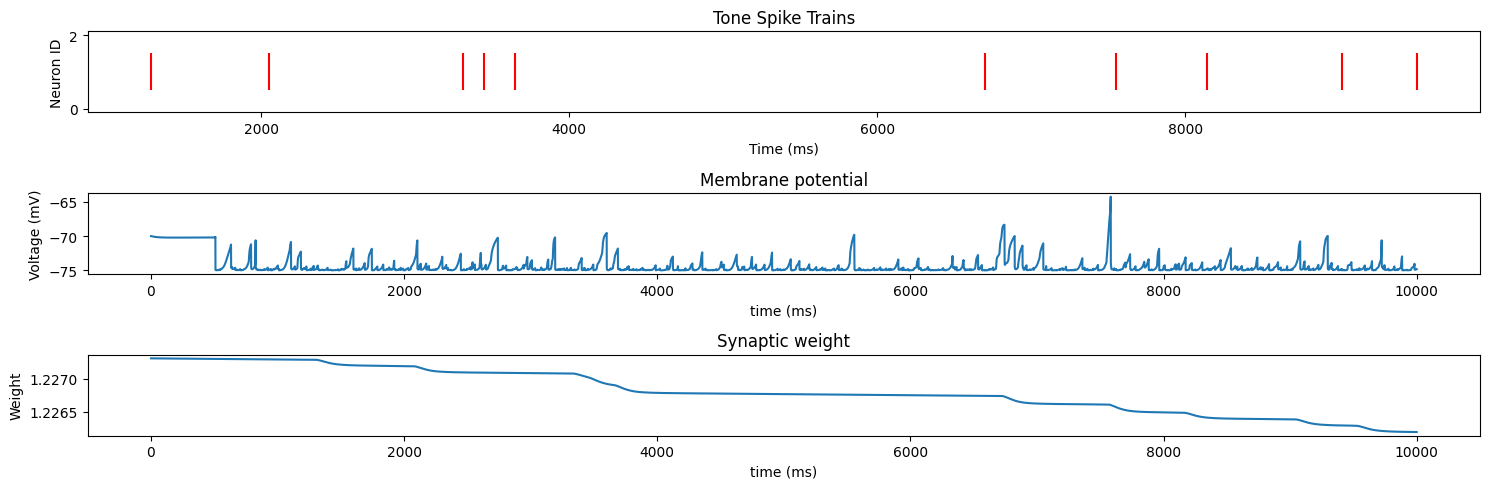

In [ ]:
from neuron import h
import numpy as np
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import ipywidgets as widgets
from IPython.display import clear_output
from neuron.units import ms, mV
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random

random.seed(1234)

def model(tone_hz, PN_hz, INT_hz, tone_w_mean, tone_w_std, PN_w_mean, PN_w_std, INT_w_mean, INT_w_std, num_PN, num_INT):
    def lognorm(mean,std):
        mean = float(mean)
        std = float(std)
        mean_ = np.log(mean) - 0.5 * np.log((std/mean)**2+1)
        std_ = np.sqrt(np.log((std/mean)**2 + 1))
        num = float(np.random.lognormal(mean_,std_))
        if num > mean*5:    #limit weights 
            num = mean*5
        return num
    
    clear_output()

    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc') 
    h.dt = 0.1
    h.tstop = 10000
    h.v_init = -70  # initial membrane potential in mV

    cell = h.PN_C()  # cell from template file

    PN_psg = PoissonSpikeGenerator(population='PN')
    PN_psg.add(
        node_ids=range(num_PN),
        firing_rate=PN_hz,   
        times=(0.5, 10))

    INT_psg = PoissonSpikeGenerator(population='INT')
    INT_psg.add(
        node_ids=range(num_INT),
        firing_rate=INT_hz,
        times=(0.5, 10))

    tone_psg = PoissonSpikeGenerator(population='tone')
    tone_psg.add(
        node_ids=range(5),
        firing_rate=tone_hz,
        times=(0.5, 10))

    # needed for saving each syn or will get overwritten
    pn_nc = []
    pn_synapses = []
    pn_vec = []
    pn_vecstim = []

    pv_nc = []
    pv_synapses = []
    pv_vec = []
    pv_vecstim = []

    for i in range(num_PN):
        conn_exc = h.bg2pyr(cell.dend[0](0.5))
        conn_exc.initW = lognorm(PN_w_mean, PN_w_std)
        spikes_exc = PN_psg.get_times(node_id=i) 
        v_spikes_exc = h.Vector(spikes_exc)
        vec_stim_exc = h.VecStim()
        vec_stim_exc.play(v_spikes_exc)
        nc_e = h.NetCon(vec_stim_exc, conn_exc, 1, 1, 1)

        pn_synapses.append(conn_exc)
        pn_vec.append(v_spikes_exc)
        pn_vecstim.append(vec_stim_exc)
        pn_nc.append(nc_e)

    for i in range(num_INT):
        conn_int = h.Exp2Syn(cell.soma[0](0.5))
        conn_int.e = -75
        spikes_int = INT_psg.get_times(node_id=i) 
        v_spikes_int = h.Vector(spikes_int)
        vec_stim_int = h.VecStim()
        vec_stim_int.play(v_spikes_int)
        nc_i = h.NetCon(vec_stim_int, conn_int, 1, 1, lognorm(INT_w_mean, INT_w_std))
        
        pv_synapses.append(conn_int)
        pv_vec.append(v_spikes_int)
        pv_vecstim.append(vec_stim_int)
        pv_nc.append(nc_i)

    conn_tone = h.pyr2pyr(cell.dend[0](0.5))
    conn_tone.initW = lognorm(tone_w_mean, tone_w_std)
    spikes_tone = tone_psg.get_times(node_id=3) 
    v_spikes_tone = h.Vector(spikes_tone)
    vec_stim_tone = h.VecStim()
    vec_stim_tone.play(v_spikes_tone)
    nc_tone = h.NetCon(vec_stim_tone, conn_tone, 1, 1, 1)

    # Recordings
    t = h.Vector()
    Soma_v = h.Vector()
    W = h.Vector()
    t.record(h._ref_t) 
    Soma_v.record(cell.soma[0](0.5)._ref_v)
    W.record(conn_tone._ref_W)

    # runs sims
    h.finitialize(h.v_init * mV) 
    h.continuerun(h.tstop * ms)

    display(ui)
    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[1,1,1])

    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[2,0])

    ax0.eventplot(spikes_tone, colors='r')
    ax0.set_title('Tone Spike Trains')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylabel('Neuron ID')

    ax1.plot(t, Soma_v)
    ax1.set_title('Membrane potential')
    ax1.set_xlabel("time (ms)")
    ax1.set_ylabel("Voltage (mV)")

    ax2.plot(t, W)
    ax2.set_title('Synaptic weight')
    ax2.set_xlabel("time (ms)")
    ax2.set_ylabel("Weight")
    plt.show()      

# Default parameter values
default_parameters = {
    "Tone Hz": 1,
    "PN Hz": 1,
    "INT Hz": 1,
    "Tone W Mean": 1,
    "Tone W Std": 1,
    "PN W Mean": 1,
    "PN W Std": 1,
    "INT W Mean": 1,
    "INT W Std": 1,
    "Num PN": 20,
    "Num INT": 20
}

# Create sliders for each parameter
w_tone_hz = widgets.FloatSlider(value=default_parameters['Tone Hz'], min=0.5, max=20, step=0.5, description='Tone Hz', style=dict(description_width='initial'))
w_PN_hz = widgets.FloatSlider(value=default_parameters['PN Hz'], min=0.5, max=20, step=0.5, description='PN Hz', style=dict(description_width='initial'))
w_INT_hz = widgets.FloatSlider(value=default_parameters['INT Hz'], min=0.5, max=20, step=0.5, description='INT Hz', style=dict(description_width='initial'))
w_tone_w_mean = widgets.FloatSlider(value=default_parameters['Tone W Mean'], min=0.5, max=15, step=0.5, description='Tone W Mean', style=dict(description_width='initial'))
w_tone_w_std = widgets.FloatSlider(value=default_parameters['Tone W Std'], min=0.5, max=5, step=0.5, description='Tone W Std', style=dict(description_width='initial'))
w_PN_w_mean = widgets.FloatSlider(value=default_parameters['PN W Mean'], min=0.5, max=15, step=0.5, description='PN W Mean', style=dict(description_width='initial'))
w_PN_w_std = widgets.FloatSlider(value=default_parameters['PN W Std'], min=0.5, max=5, step=0.5, description='PN W Std', style=dict(description_width='initial'))
w_INT_w_mean = widgets.FloatSlider(value=default_parameters['INT W Mean'], min=0.5, max=15, step=0.5, description='INT W Mean', style=dict(description_width='initial'))
w_INT_w_std = widgets.FloatSlider(value=default_parameters['INT W Std'], min=0.5, max=5, step=0.5, description='INT W Std', style=dict(description_width='initial'))
w_num_PN = widgets.IntSlider(value=default_parameters['Num PN'], min=1, max=50, step=1, description='Num PN', style=dict(description_width='initial'))
w_num_INT = widgets.IntSlider(value=default_parameters['Num INT'], min=1, max=50, step=1, description='Num INT', style=dict(description_width='initial'))

# Create run button
w_run = widgets.Button(description='Run', icon='play', button_style='primary')

# Create reset button
w_reset = widgets.Button(description="Reset", disabled=False, button_style='info', tooltip='Reset parameters', icon='refresh')

# Define function to run the model
def run_model(event):
    model(
        w_tone_hz.value, w_PN_hz.value, w_INT_hz.value,
        w_tone_w_mean.value, w_tone_w_std.value,
        w_PN_w_mean.value, w_PN_w_std.value,
        w_INT_w_mean.value, w_INT_w_std.value,
        w_num_PN.value, w_num_INT.value
    )

# Define function to reset sliders
def reset_sliders(event):
    for w_slider in [w_tone_hz, w_PN_hz, w_INT_hz, w_tone_w_mean, w_tone_w_std, w_PN_w_mean, w_PN_w_std, w_INT_w_mean, w_INT_w_std, w_num_PN, w_num_INT]:
        w_slider.value = default_parameters[w_slider.description]

# Link run button to run_model function
w_run.on_click(run_model)

# Link reset button to reset_sliders function
w_reset.on_click(reset_sliders)

# Display sliders, buttons, and plot
ui = VBox([HBox([w_run, w_reset]),
           HBox([w_tone_hz, w_PN_hz, w_INT_hz]),
           HBox([w_tone_w_mean, w_PN_w_mean, w_INT_w_mean]), 
           HBox([w_tone_w_std, w_PN_w_std, w_INT_w_std]), 
           HBox([w_num_PN, w_num_INT])])

display(ui)


## Questions

- ### 1. Explain the results in the top two plots in the default setting. Provide your reasoning for each of the plots without missing any detail. Omit the third plot related to the change in the tone-PN synaptic weight.
- ### 2. Set the tone frequency to 5 Hz, and find settings that will provide an average firing rate of 1 Hz for the postsynaptic neuron. Note there are multiple solutions - you decide which ones, based on your answer to question 1.
- ### 3. Now that you perhaps understand the first two plots, try to explain what you see in the third plot of change in synaptic weight. You can revisit a prior tutorial that focused on tone-shock pairing. 
- ### 4. Finally, summarize your learning by listing in itemized form the key concepts that you have learned from this tutorial.